In [2]:
# Data processing
import pandas as pd
# Scientific computing
import scipy
# Regular expression operations
import re
# Common string operations
import string 
# Time
import time

# Interpret the results of the LDA model
import pyLDAvis
# Interactive data visualization
import pyLDAvis.gensim_models as gensimvis

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Unsupervised topic modeling, document indexing.
import gensim
# Mapping of the words to integers
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import Phrases, phrases

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Natural language processing
import nltk 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

nltk.download('wordnet') 
nltk.download('punkt')
nltk.download('stopwords')

# formatting
from pprint import pprint
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# set pd column width
pd.set_option('display.max_colwidth', 20)

<frozen importlib._bootstrap>:488: DeprecationWarning: Type google._upb._message.MessageMapContainer uses PyType_Spec with a metaclass that has custom tp_new. This is deprecated and will no longer be allowed in Python 3.14.
<frozen importlib._bootstrap>:488: DeprecationWarning: Type google._upb._message.ScalarMapContainer uses PyType_Spec with a metaclass that has custom tp_new. This is deprecated and will no longer be allowed in Python 3.14.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\skybl\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\skybl\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\skybl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [69]:
def import_data(dir: str) -> pd.DataFrame:
    df = pd.read_csv(dir)
    return df

In [5]:
def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    data = pd.DataFrame()

    # Get relevant data
    data["title"] = df["title"].fillna("")
    data["body"] = df["body"].fillna("")

    # Combine title and body
    data["text"] = data["title"] + " " + data["body"]

    # Remove links
    data["processed"] = data["text"].map(lambda x: re.sub(r"http\S+", "", x))

    # Remove punctuation
    data["processed"] = data["processed"].map(lambda x: x.translate(str.maketrans("", "", string.punctuation)))

    # Convert to lowercase
    data["processed"] = data["processed"].map(lambda x: x.lower())

    # Tokenize
    data["processed"] = data["processed"].map(word_tokenize)

    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    data["processed"] = data["processed"].map(lambda x: [word for word in x if word not in stop_words])

    # Remove words with less than 3 characters
    data["processed"] = data["processed"].map(lambda x: [word for word in x if len(word) >= 3])

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    data["processed"] = data["processed"].map(lambda x: [lemmatizer.lemmatize(word) for word in x])

    # Stemming
    # stemmer = PorterStemmer()
    # data['processed'] = data['processed'].map(lambda x: [stemmer.stem(word) for word in x])

    # Remove rows with less than 5 words
    data = data[data["processed"].map(len) >= 10]

    # Remove unnecessary columns
    data.drop(["title", "body"], axis=1, inplace=True)

    # reset index
    data.reset_index(drop=True, inplace=True)

    return data

In [6]:
subreddits = ["artificial","MachineLearning","ArtificialInteligence"]
data = pd.concat([pd.read_csv(f"../backend/data/{subreddit}.csv") for subreddit in subreddits])
data = preprocess_data(data)


vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 3), max_df=0.7, min_df=0.1)
features = vectorizer.fit_transform(data["processed"].apply(lambda x: " ".join(x)))


In [7]:
wcss = []
for i in range(1, 50):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=132)
    kmeans.fit(features)
    wcss.append(kmeans.inertia_)

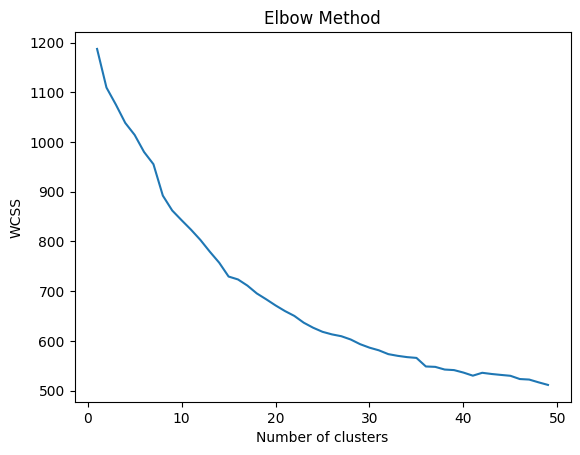

In [8]:
# plot elbow method
plt.plot(range(1, 50), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [9]:
k = 20
model = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1)
model.fit(features)


KMeans(max_iter=100, n_clusters=20, n_init=1)

In [10]:
print("Cluster centroids: \n")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print("--------------------")

Cluster centroids: 

Cluster 0:
 want
 know
 way
 like
 time
 think
 use
 good
 work
 make
--------------------
Cluster 1:
 tool
 video
 new
 work
 use
 like
 help
 create
 make
 using
--------------------
Cluster 2:
 video
 question
 year
 think
 make
 work
 thing
 know
 way
 good
--------------------
Cluster 3:
 like
 think
 good
 create
 way
 thing
 dont
 really
 know
 make
--------------------
Cluster 4:
 llm
 new
 like
 tool
 model
 using
 data
 think
 good
 work
--------------------
Cluster 5:
 model
 like
 know
 use
 work
 best
 using
 dont
 learning
 data
--------------------
Cluster 6:
 llm
 model
 data
 new
 work
 like
 question
 using
 different
 use
--------------------
Cluster 7:
 time
 like
 dont
 work
 know
 way
 question
 model
 learning
 make
--------------------
Cluster 8:
 learning
 like
 model
 work
 data
 using
 time
 use
 need
 llm
--------------------
Cluster 9:
 use
 like
 example
 know
 make
 model
 using
 question
 help
 different
--------------------
Cluster 